## Introduction
In this notebook, I apply collaborative filtering (from scratch) for movie recommendations. The dataset contains 100836 ratings by 610 users across 9742 movies. 

The model has no information about the movies except user ratings. The attempt is to extract valuable information about the movies and the users using such limited data.
Fundamentally, this project aims to predict user rating for a movie that the user has not yet rated.

Using the derived information, we will be able to perform the following tasks - 
1) Predict movies for a given user
2) Predict how a user will rate a given movie
3) Measure the difference between two movies
4) Measure the difference between two users
5) Predict movies similar to a given movie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pickle
from itertools import combinations
matrix_dtype='float32'

### Load data
Source - https://grouplens.org/datasets/movielens/latest/ <br>
About the dataset - https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html

In [150]:
movies = pd.read_csv('ml-latest-small/movies.csv')[['movieId', 'title']]
movies

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017)
9738,193583,No Game No Life: Zero (2017)
9739,193585,Flint (2017)
9740,193587,Bungo Stray Dogs: Dead Apple (2018)


In [151]:
ratings_raw = pd.read_csv('ml-latest-small/ratings.csv')[['userId', 'movieId', 'rating']]

A lot of the movies have only 1 rating. I think this may affect the predictions by adding noise since there are not enough ratings for these movies to reliably extract the features.

The following function removes those movies that have less than a given number of ratings.

In [153]:
def filter_ratings(filter_by, df=ratings_raw):
    # removes the movies that have less number of ratings than 'filter_by'
    counts = dict(df['movieId'].value_counts())
    wanted_ids = []
    for id in counts:
        if counts[id] >= filter_by:
            wanted_ids.append(id)
    filtered_df = df[df['movieId'].isin(wanted_ids)]
    return filtered_df

In [154]:
ratings = filter_ratings(filter_by=1).copy() # try changing the 'filter_by' value; it improves recommendations in some cases

The 'movie_idx' column shows the index of the movie in the matrices

In [155]:
n_m = len(ratings.movieId.unique()) #number of movies
n_u = len(ratings.userId.unique()) #number of users
n = 20 #number of features
movie_idx = np.zeros((n_m, 2), dtype='int')
movie_idx[:, 0], movie_idx[:, 1] = np.sort(ratings.movieId.unique()), tuple(range(n_m))
movie_idx_dict = dict(movie_idx)
ratings['movie_idx'] = ratings['movieId'].map(movie_idx_dict)
ratings = ratings[['userId', 'movieId', 'movie_idx', 'rating']]
ratings

,userId,movieId,movie_idx,rating
0,1,1,0,4.0
1,1,3,2,4.0
2,1,6,5,4.0
3,1,47,43,5.0
4,1,50,46,5.0
...,...,...,...,...
100831,610,166534,9416,4.0
100832,610,168248,9443,5.0
100833,610,168250,9444,5.0
100834,610,168252,9445,5.0


In [161]:
Y = np.zeros((n_m, n_u), dtype=matrix_dtype)
W = np.random.normal(size=(n_u, n)).astype(matrix_dtype)
X = np.random.normal(size=(n_m, n)).astype(matrix_dtype)
b = np.random.normal(size=(1, n_u)).astype(matrix_dtype)
print(f"Y Shape: {Y.shape}")
print(f"W Shape: {W.shape}")
print(f"X Shape: {X.shape}")
print(f"b Shape: {b.shape}")
print(f"No. of movies (n_m): {n_m}")
print(f"No. of users (n_u): {n_u}")
print(f"No. of features (n): {n}")

Y Shape: (9724, 610)
W Shape: (610, 20)
X Shape: (9724, 20)
b Shape: (1, 610)
No. of movies (n_m): 9724
No. of users (n_u): 610
No. of features (n): 20


In [169]:
Y_rows, Y_columns = ratings['movie_idx'], ratings['userId'] - 1
Y[Y_rows, Y_columns] = ratings['rating']
R = (Y != 0).astype('int')

<b>We can also use trained parameters. These have been saved as binary files in the 'trained_parameters' folder.</b>

trained_param_2.dat seems to give good predictions.

In [9]:
def load_param(filename): # loads trained parameters
    with open(filename, 'rb') as file:
        W, X, b = pickle.load(file)
    return W, X, b

In [165]:
#W, X, b = load_param('trained_parameters/trained_param_2.dat') # comment this line if not using trained parameters

In [101]:
def mean_normalization(Y):
    # normalizes the Y matrix 
    mean = np.sum(Y, axis=1)/np.sum((Y!=0).astype('int'), axis=1).astype(matrix_dtype)
    Y_norm = Y - mean.reshape((len(mean), 1))
    return Y_norm, mean

In [170]:
Y_norm, mean_ratings = mean_normalization(Y)
Y_norm

array([[ 0.07906985, -3.9209301 , -3.9209301 , ..., -1.4209301 ,
        -0.92093015,  1.0790699 ],
       [-3.4318182 , -3.4318182 , -3.4318182 , ..., -1.4318182 ,
        -3.4318182 , -3.4318182 ],
       [ 0.7403846 , -3.2596154 , -3.2596154 , ..., -1.2596154 ,
        -3.2596154 , -3.2596154 ],
       ...,
       [-3.5       , -3.5       , -3.5       , ..., -3.5       ,
        -3.5       , -3.5       ],
       [-3.5       , -3.5       , -3.5       , ..., -3.5       ,
        -3.5       , -3.5       ],
       [-4.        , -4.        , -4.        , ..., -4.        ,
        -4.        , -4.        ]], dtype=float32)

The cost function for collaborative filtering - 
$J(w, b, x)=\frac{1}{2} \sum_{(i, j): r(i, j)=1}\left(\vec{w}^{(j)} \cdot \vec{x}^{(i)}+b^{(j)}-y^{(i, j)}\right)^2+\frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^n\left(w_k^{(j)}\right)^2+\frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n\left(x_k^{(i)}\right)^2$

In [102]:
def compute_cost(Y, R, W, X, b, lambda_):
    # computes cost
    J = 0.5*np.sum((((X@W.T + b) - Y)*R)**2)
    reg_1 = (lambda_/2)*np.sum(X**2)
    reg_2 = (lambda_/2)*np.sum(W**2)
    cost = J+reg_1+reg_2
    return cost

In [162]:
print(f"Initial Cost: {compute_cost(Y_norm, R, W, X, b, 0.5)}")

Initial Cost: 1157087.9017758418


The following function measures the mean difference between the predicted and the actual ratings. 

In [130]:
def measure_diff():
    # returns the mean difference b/w ratings and predictions for all the ratings
    predicted_ratings = ((X@W.T + b).T + mean_ratings).T*R
    absolute_diff = np.fabs(predicted_ratings - Y)
    mean_diff = np.sum(absolute_diff)/np.sum(R)
    print(f"Mean Difference: {mean_diff}")

<b>Since we have not trained the model yet, the mean difference is very high. Basically, this is the difference, on average, between any particular predicted and actual rating.</b>

<b>Right now, the predicted and actual ratings differ by ~4.7, on average.</b>

In [163]:
measure_diff()

Mean Difference: 4.696184679804067


<b>Update rules - </b> <br>
$\begin{aligned} & w_k^{(j)}:=w_k^{(j)}-\frac{\partial}{\partial w_k^{(j)}} J(w, b, x) \\ & b^{(j)}:=b^{(j)}-\frac{\partial}{\partial b^{(j)}} J(w, b, x) \\ & x_k^{(i)}:=x_k^{(i)}-\frac{\partial}{\partial x_k^{(i)}} J(w, b, x)\end{aligned}$

<b>Gradients - </b> <br>
$\begin{aligned} & \frac{\partial}{\partial w_k^{(j)}} J(w, b, x)=\sum_{(i, j): r(i, j)=1}\left(\vec{w}^{(j)} \cdot \vec{x}^{(i)}+b^{(j)}-y^{(i, j)}\right) x_k^{(i)}+\lambda w(j) \\ & \frac{\partial}{\partial b^{(j)}} J(w, b, x)=\sum_{(i, j): r(i, j)=1}\left(\vec{w}^{(j)} \cdot \vec{x}^{(i)}+b^{(j)}-y^{(i, j)}\right) \\ & \frac{\partial}{\partial x_k^{(i)}} J(w, b, x)=\sum_{(i, j): r(i, j)=1}\left(\vec{w}^{(j)} \cdot \vec{x}^{(i)}+b^{(j)}-y^{(i, j)}\right) w_k^{(j)}+\lambda x_k^{(i)}\end{aligned}$

In [104]:
def compute_gradient(Y, R, W, X, b, lambda_):
    # computes gradients for all the parameters. (Vectorized implementation)
    # Returns matrices dj_dW, dj_db, dj_dX, which have the same shape as W, b, and X, respectively.
    n_m, n_u = Y.shape
    n = X.shape[1]
    com_term = (((X@W.T + b) - Y)*R).astype(matrix_dtype)
    com_term_broad = (com_term*np.ones((n, n_m, n_u))).astype(matrix_dtype)
    X_broad = ((X*np.ones((n_u, n_m, n))).swapaxes(0, 2)).astype(matrix_dtype)
    W_broad = ((W.T*np.ones((n_m, n, n_u))).swapaxes(0, 1)).astype(matrix_dtype)
    
    dj_dW = (np.sum(com_term_broad*X_broad, axis=1).T + (lambda_*W))
    dj_db = np.sum(com_term, axis=0)
    dj_dX = np.sum(com_term_broad*W_broad, axis=2).T + (lambda_*X)
    return dj_dW, dj_db, dj_dX

In [105]:
def gradient_descent(num_iters, alpha, lambda_, hyperparam, decay_rate, Y, R, W, X, b):
    # Performs gradient descent (with Adam)
    j_hist = []
    V_W = np.zeros(W.shape, dtype=matrix_dtype)
    V_b = np.zeros(b.shape, dtype=matrix_dtype)
    V_X = np.zeros(X.shape, dtype=matrix_dtype)
    S_W = np.zeros(W.shape, dtype=matrix_dtype)
    S_b = np.zeros(b.shape, dtype=matrix_dtype)
    S_X = np.zeros(X.shape, dtype=matrix_dtype)
    j_hist.append(compute_cost(Y, R, W, X, b, lambda_))
    print(f"J at iter 0: {j_hist[0]}")
    for i in range(1, num_iters+1):
        alpha_ = alpha/(1+(i*decay_rate))
        dj_dW, dj_db, dj_dX = compute_gradient(Y, R, W, X, b, lambda_)
        beta1, beta2, E = hyperparam
        V_W, V_b, V_X = beta1*V_W + (1-beta1)*dj_dW, beta1*V_b + (1-beta1)*dj_db, beta1*V_X + (1-beta1)*dj_dX
        S_W, S_b, S_X = beta2*S_W + (1-beta2)*(dj_dW**2), beta2*S_b + (1-beta2)*(dj_db**2), beta2*S_X + (1-beta2)*(dj_dX**2)
        V_W_c, V_b_c, V_X_c = V_W/(1-beta1**i), V_b/(1-beta1**i), V_X/(1-beta1**i)
        S_W_c, S_b_c, S_X_c = S_W/(1-beta2**i), S_b/(1-beta2**i), S_X/(1-beta2**i)
        W = W - ((alpha_/(np.sqrt(S_W_c)+E))*V_W_c)
        b = b - ((alpha_/(np.sqrt(S_b_c)+E))*V_b_c)
        X = X - ((alpha_/(np.sqrt(S_X_c)+E))*V_X_c)
        
        j = compute_cost(Y, R, W, X, b, lambda_)
        j_hist.append(j)
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            print(f"J at iter {i}: {j}")
    return W, b, X, j_hist

There are 207290 parameters in this project and all have been trained using Adaptive Moment Estimation (Adam) in a vectorized manner with regularization.

In [17]:
def fit(num_iters, alpha, lambda_, hyperparam, decay_rate=0, Y=Y_norm, R=R, W=W, X=X, b=b):
    start_time = time.time()
    W, b, X, j_hist = gradient_descent(num_iters, alpha, lambda_, hyperparam, decay_rate, Y, R, W, X, b)
    end_time = time.time()
    print(f"Training time: {end_time-start_time}")
    return W, b, X, j_hist

In [18]:
W, b, X, j_hist = fit(300, 0.5, 0.5, (0.96, 0.999, 1e-08))

J at iter 0: 1108811.5032036921
J at iter 30: 82034.78119478197
J at iter 60: 35099.49443182199
J at iter 90: 18891.25707960209
J at iter 120: 12111.371702438431
J at iter 150: 9388.473693786415
J at iter 180: 8382.59582770039
J at iter 210: 7998.402324621784
J at iter 240: 7828.717712058288
J at iter 270: 7741.140992510787
J at iter 299: 7686.1324752342425
J at iter 300: 7684.604663264911
Training time: 791.2158029079437


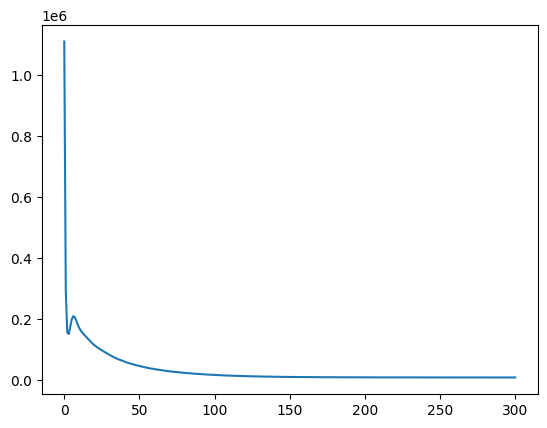

In [19]:
plt.plot(j_hist)

### Predict movies for a given user

In [106]:
def user_prediction(user_id, recommend_movies=5):
    # First prints 10 highest rated movies by the user (Indicative of user's taste).
    # Then returns movies that the user is likely to give highest ratings to.
    # The number of movies recommended is determined by the 'recommend_movies' parameter.
    user_id -= 1
    movies_rated = np.sum(R[:, user_id])
    print(f"User {user_id+1} has rated {movies_rated} movies\n")
    most_liked_idx = np.argpartition(Y[:, user_id], -10)[-10:]
    most_liked_idx = most_liked_idx[np.argsort(Y[:, user_id][most_liked_idx])][::-1]
    
    most_liked_movie_ids = movie_idx[[np.where(movie_idx[:, 1] == idx)[0][0] for idx in most_liked_idx]][:, 0]
    
    most_liked_movies = movies[movies['movieId'].isin(most_liked_movie_ids)].copy() # extract the most liked movies (not Ordered)
    most_liked_movies['movieId'] = pd.Categorical(most_liked_movies['movieId'], categories=most_liked_movie_ids, ordered=True)
    most_liked_movies = most_liked_movies.sort_values('movieId')
    
    print(f"******** User {user_id+1} liked the following movies - ********\n")
    print(most_liked_movies.to_string(index=False) + "\n")
    
    user_ratings_vector = (np.sum(W[user_id]*X, axis=1) + b[0][user_id] + mean_ratings)*(R[:, user_id] == 0).astype('int')
    # in the user_ratings_vector, the movies already rated by the user are rated 0
    
    rec_idx = np.argpartition(user_ratings_vector, -recommend_movies)[-recommend_movies:]
    rec_idx = rec_idx[np.argsort(user_ratings_vector[rec_idx])][::-1]
    
    rec_movie_ids = movie_idx[[np.where(movie_idx[:, 1] == idx)[0][0] for idx in rec_idx]][:, 0]
    
    rec_movies = movies[movies['movieId'].isin(rec_movie_ids)].copy()
    rec_movies['movieId'] = pd.Categorical(rec_movies['movieId'], categories=rec_movie_ids, ordered=True)
    rec_movies = rec_movies.sort_values('movieId')
    
    print(f"******** Recommendations for User {user_id+1} - ********\n")
    print(rec_movies.to_string(index=False))
    
    

<b>We can see that user 30 has a Sci-fi/Action taste in movies. The recommendations also seem to reflect (mostly) a similar genre.</b>

In [206]:
user_prediction(30, 20)

User 30 has rated 34 movies

******** User 30 liked the following movies - ********

movieId                                                                          title
   1291                                      Indiana Jones and the Last Crusade (1989)
   1198 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
   1196                          Star Wars: Episode V - The Empire Strikes Back (1980)
  68358                                                               Star Trek (2009)
  79132                                                               Inception (2010)
    260                                      Star Wars: Episode IV - A New Hope (1977)
  93510                                                          21 Jump Street (2012)
    318                                               Shawshank Redemption, The (1994)
 111759                                                        Edge of Tomorrow (2014)
  58559                                      

<b>After training the parameters, the mean difference has come down by a lot!</b>

<b>The actual and predicted ratings only differ by 0.21, on average.</b>

In [171]:
measure_diff()

Mean Difference: 0.21640953584648975


In [134]:
def measure_user_diff(user_id):
    # returns the mean difference b/w user ratings and predictions
    user_id -= 1
    actual_ratings = Y[:, user_id]
    predicted_ratings = (np.sum(W[user_id]*X, axis=1) + b[0][user_id] + mean_ratings)*R[:, user_id]
    mean_difference = np.sum(np.fabs(actual_ratings - predicted_ratings))/np.sum(R[:, user_id])
    print(f"Mean Difference for User {user_id+1}: {mean_difference}")

<b>We can also get the mean difference for a particular user.</b>

In [172]:
measure_user_diff(30)

Mean Difference for User 30: 0.1855604648590088


### Predict how a user will rate a particular movie

In [173]:
def predict(user_id, movie_id):
    # predicts user_id's rating for movie_id
    # this movie_id is the actual movie id and not the matrix index
    user_id -= 1
    print(movies[movies['movieId'] == movie_id].to_string(index=False) + "\n")
    if movie_id in movie_idx_dict:
        movie_index = movie_idx_dict[movie_id]
        prediction = np.dot(W[user_id], X[movie_index]) + b[0][user_id] + mean_ratings[movie_index]
        actual = Y[movie_index][user_id]
        if actual == 0:
            actual = "Not Rated"
        print(f"Predicted rating: {prediction} | Actual Rating: {actual}")
    else:
        print("Can not predict. No ratings for this movie available")
        

<b>We can see that user 30 has rated the movie <i>'Interstellar'</i> as 5.0. The model predicts ~4.9 for the same, which is a very good prediction.</b>

In [95]:
predict(30, 109487)

 movieId               title
  109487 Interstellar (2014)

Predicted rating: 4.918183326721191 | Actual Rating: 5.0


<b>User 30 has not rated <i>'The Martian'</i>. Since the user likes sci-fi movies (reflected by their highest rated movies), we can expect that user 30 will give a high rating to 'The Martian' as it is a sci-fi movie.</b>

<b>The model predicts ~4.8, which matches our intuition.</b>

In [174]:
predict(30, 134130)

 movieId              title
  134130 The Martian (2015)

Predicted rating: 4.787964820861816 | Actual Rating: Not Rated


<b>User 30 doesn't really seem to enjoy romance movies, so we would expect that they would give a low rating to a romance movie.</b>

<b>Again, the prediction for <i>'Never Been Kissed'</i> matches our intuition.</b>

In [84]:
predict(30, 2581)

 movieId                    title
    2581 Never Been Kissed (1999)

Predicted rating: 3.148394823074341 | Actual Rating: Not Rated


### Predict the difference between two movies

The following function gives a measure of difference between two movies.
The higher this number, the more different the two movies.

In [183]:
def movie_difference(movie_1_id, movie_2_id):
    # This function gives a measure of how different two movies are.
    # The higher this number, the more different the movies.
    movie_1_name = movies[movies['movieId'] == movie_1_id]
    print(f"Movie 1: {movie_1_name.values.tolist()[0]}")
    movie_2_name = movies[movies['movieId'] == movie_2_id]
    print(f"Movie 2: {movie_2_name.values.tolist()[0]}")

    idx_1, idx_2 = movie_idx_dict[movie_1_id], movie_idx_dict[movie_2_id]

    diff = np.sum((X[idx_1] - X[idx_2])**2)
    print(f"Measure of difference: {diff}")

<b><i>'Interstellar'</i> and <i>'Pride & Prejudice'</i> are very different movies.</b>

<b> Therefore, the model returns a high (~6.3) measure of difference. </b>

In [190]:
movie_difference(109487, 40629)

Movie 1: [109487, 'Interstellar (2014)']
Movie 2: [40629, 'Pride & Prejudice (2005)']
Measure of difference: 6.304194927215576


<b>Again, <i>'Edge of Tomorrow'</i> and <i>'Titanic'</i> are very different movies.</b>

<b> Therefore, the model returns a high (~5.2) measure of difference. </b>

In [185]:
movie_difference(111759, 1721)

Movie 1: [111759, 'Edge of Tomorrow (2014)']
Movie 2: [1721, 'Titanic (1997)']
Measure of difference: 5.162797451019287


<b><i>'The Martian'</i> and <i>'Interstellar'</i> are pretty similar.</b>

<b> Therefore, the model returns a low (~1.9) measure of difference indicating that the movies are similar. </b>

In [186]:
movie_difference(134130, 109487)

Movie 1: [134130, 'The Martian (2015)']
Movie 2: [109487, 'Interstellar (2014)']
Measure of difference: 1.8670133352279663


<b><i>'The Amazing Spider-Man'</i> and <i>'The Amazing Spider-Man 2'</i> are very similar movies. They are part of the same series.</b>

<b> Therefore, the model returns a low (~2.5) measure of difference. Ideally, the value should be lower as the movies are very similar, but we should keep in mind that the model has no information about the movies except ratings. We can not expect perfect behaviour in every case. </b>

In [187]:
movie_difference(95510, 110553)

Movie 1: [95510, 'Amazing Spider-Man, The (2012)']
Movie 2: [110553, 'The Amazing Spider-Man 2 (2014)']
Measure of difference: 2.7574126720428467


<b>Again, <i>'The Dark Knight'</i> and <i>'The Dark Knight Rises'</i> are very similar movies. They are part of the same series.</b>

<b> Therefore, the model returns a very low (~0.6) measure of difference. The result is better than the previous case.</b>

In [188]:
movie_difference(58559, 91529)

Movie 1: [58559, 'Dark Knight, The (2008)']
Movie 2: [91529, 'Dark Knight Rises, The (2012)']
Measure of difference: 0.5738054513931274


<b><i>'The Godfather'</i> and <i>'The Godfather: Part II'</i> are also sequels.</b>

<b> Therefore, the model returns a very low (only ~0.2) measure of difference.</b>

In [189]:
movie_difference(858, 1221)

Movie 1: [858, 'Godfather, The (1972)']
Movie 2: [1221, 'Godfather: Part II, The (1974)']
Measure of difference: 0.2098020315170288


<b><i>'Iron Man'</i> and <i>'Batman Begins'</i> are similar. They are both superhero movies.</b>

<b> Therefore, the model returns a low (~1.0) measure of difference.</b>

In [194]:
movie_difference(59315, 33794)

Movie 1: [59315, 'Iron Man (2008)']
Movie 2: [33794, 'Batman Begins (2005)']
Measure of difference: 1.0270766019821167


### Predict the difference between two users
Just as we did for movies, we can also get a measure of difference for two users. The higher this number, the more difference the two users.

In [199]:
def user_difference(user1, user2):
    user1 -= 1
    user2 -= 1
    diff = np.sum((W[user1]-W[user2])**2)
    print(f"Measure of difference: {diff}")

<b> Users 30 and 69 share a somewhat similar taste. They both like sci-fi/action movies (can be checked using the 'user_prediction' function). </b>

In [207]:
user_difference(30, 69)

Measure of difference: 4.820165634155273


<b>Users 30 and 12 have dissimilar preferences. User 12 likes romance/drama movies whereas 30 prefers sci-fi/action ones.</b>

<b>As expected, the measure of difference is higher than the previous case when the user shared similar tastes.</b>

In [208]:
user_difference(30, 12)

Measure of difference: 7.214715003967285


### Predict movies similar to a given movie

In [196]:
def similar_movies(movie_id, num_rec=10):
    #Prints movies similar to a given movie. Returns 10 movies by default.
    movie_name = movies[movies['movieId'] == movie_id]
    print(f"Movie: {movie_name.values.tolist()[0]} \n")
    movie_index = movie_idx_dict[movie_id]

    diff_vector = np.sum((X - X[movie_index])**2, axis=1)
    similar_idx = np.argpartition(diff_vector, (num_rec+1))[:(num_rec+1)]
    similar_idx = similar_idx[np.argsort(diff_vector[similar_idx])][1:]

    similar_movie_ids = movie_idx[[np.where(movie_idx[:, 1] == idx)[0][0] for idx in similar_idx]][:, 0]
    
    similar_movies = movies[movies['movieId'].isin(similar_movie_ids)].copy() 
    similar_movies['movieId'] = pd.Categorical(similar_movies['movieId'], categories=similar_movie_ids, ordered=True)
    similar_movies = similar_movies.sort_values('movieId')
    print(similar_movies.to_string(index=False))

In [35]:
similar_movies(858)

Movie: [858, 'Godfather, The (1972)'] 

movieId                                 title
   1221        Godfather: Part II, The (1974)
   5993                            Max (2002)
   4103              Empire of the Sun (1987)
   1635                 Ice Storm, The (1997)
   1213                     Goodfellas (1990)
   2474            Color of Money, The (1986)
    482                    Killing Zoe (1994)
   2163 Attack of the Killer Tomatoes! (1978)
   1202                   Withnail & I (1987)
   4229                Say It Isn't So (2001)


In [36]:
similar_movies(1196)

Movie: [1196, 'Star Wars: Episode V - The Empire Strikes Back (1980)'] 

movieId                                             title
    260         Star Wars: Episode IV - A New Hope (1977)
   1210 Star Wars: Episode VI - Return of the Jedi (1983)
   1291         Indiana Jones and the Last Crusade (1989)
  65642            Timecrimes (Cronocrímenes, Los) (2007)
 170355                             Mulholland Dr. (1999)
   4142                     Left Behind: The Movie (2000)
   5202                       Mon oncle d'Amérique (1980)
   1858              Mr. Nice Guy (Yat goh ho yan) (1997)
   1086                          Dial M for Murder (1954)
  52885                         Paprika (Papurika) (2006)


In [57]:
similar_movies(89745)

Movie: [89745, 'Avengers, The (2012)'] 

movieId                              title
 112852     Guardians of the Galaxy (2014)
  59315                    Iron Man (2008)
  91529      Dark Knight Rises, The (2012)
   2316             Practical Magic (1998)
  58559            Dark Knight, The (2008)
  66203 He's Just Not That Into You (2009)
  33794               Batman Begins (2005)
 111362  X-Men: Days of Future Past (2014)
  72641            Blind Side, The  (2009)
   8972           National Treasure (2004)


In [66]:
similar_movies(33794)

Movie: [33794, 'Batman Begins (2005)'] 

movieId                         title
  58559       Dark Knight, The (2008)
  91529 Dark Knight Rises, The (2012)
   2458    Armed and Dangerous (1986)
   4719          Osmosis Jones (2001)
  78893    Last Airbender, The (2010)
 152081               Zootopia (2016)
   5075            Waydowntown (2000)
   1855    Krippendorf's Tribe (1998)
   3235 Where the Buffalo Roam (1980)
   3793                  X-Men (2000)


In [39]:
similar_movies(91542)

Movie: [91542, 'Sherlock Holmes: A Game of Shadows (2011)'] 

movieId                   title
  73017  Sherlock Holmes (2009)
  51540           Zodiac (2007)
   3952   Contender, The (2000)
   1682 Truman Show, The (1998)
   8869   First Daughter (2004)
 140174             Room (2015)
  32289     Ice Princess (2005)
   4155   Sweet November (2001)
   3912        Beautiful (2000)
    378       Speechless (1994)


In [49]:
similar_movies(356)

Movie: [356, 'Forrest Gump (1994)'] 

movieId                                    title
   2797                               Big (1988)
   4995                 Beautiful Mind, A (2001)
   3271                   Of Mice and Men (1992)
   4047                        Gettysburg (1993)
   1439                 Meet Wally Sparks (1997)
   4340                       Animal, The (2001)
   1445                     McHale's Navy (1997)
 110553          The Amazing Spider-Man 2 (2014)
   3061                       Holiday Inn (1942)
   8695 Bachelor and the Bobby-Soxer, The (1947)


In [198]:
def save_parameters(W, X, b, filename):
    # To save the learned parameters in a binary file.
    data = (W, X, b)
    with open(filename, 'wb') as file:
        pickle.dump(data, file)

In [197]:
#save_parameters(W, X, b, 'filename')

## Conclusion

Using very limited data about the movies and the users, we were able to extract valuable information and make productive inferences. 